# Creating a Character Dataset for Transfer Learning

Since it appeared that there was a lack of of simpler models trained with the a single color channel, I decided to explore the merits of creating one from scratch using unutilized data in the dataset and supplementing it with the publicly available [EMNIST dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset) (an extension of [the MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/))

## Imports

In [1]:
#Library imports
import re
import os
import sys
import shutil
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

from IPython.display import Image, display
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from tensorflow.keras import models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2


# Allows access to scripts and modules relative to the parent directory.
parent = os.path.dirname(os.getcwd())
sys.path.append(parent)


#User Created functions

from cleaning_functions import *
from eda_functions import *
from modeling_functions import *
from setup_functions import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
#Without this block the Japanese font's won't display properly in Matplotlib.Set to your font directory.
extend_matplotlib_fonts("/usr/share/fonts/")

/home/anacuda/work/nyc-mhtn-ds-021720/japanese_text_classifiers/setup_functions.py:23: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [3]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

## Organizing and splitting the data

### Kuzushiji Kanji

The Kuzushiji Kanji dataset is an especially attractive choice for transfer learning because of the myriad of character classifiers it provides which will enhance the generality of the lower convolutional layers.

In [5]:
#Creates relative paths for the source directory and the destination when duplicates of the images are split into training/testing groups
orig_kuzushiji_kanji_dir = 'data/kuzushiji49/kkanji2'
split_kanji_dir = "data/kuzushiji49/kanji_transfer"

However the strong imbalance of this dataset combined with the low ratio of observations to classes make this dataset challenging to use. In many classes, observations are so scarce that this data would be unusable for standalone predictions.

In [216]:
directory_sizes = [[directory, len(os.listdir(f"{orig_kuzushiji_kanji_dir}/{directory}"))] for directory in os.listdir(orig_kuzushiji_kanji_dir)]
directory_counts = pd.DataFrame(directory_sizes, columns=["folder", "count"])
directory_counts["char"] = directory_counts["folder"].map(lambda x: chr(int(x[2:], 16)))
directory_counts

,folder,count,char
0,U+5375,197,卵
1,U+5BC6,30,密
2,U+85A6,6,薦
3,U+8DE1,109,跡
4,U+7409,2,琉
...,...,...,...
3827,U+5B63,37,季
3828,U+75B3,2,疳
3829,U+9322,9,錢
3830,U+675C,12,杜


I needed to maximize the amount of data without hindering the predictive strength of the data, so I plotted how the size of the dataset changes across different thresholds of minimum observations per class.

In [205]:
#Creates a dataframe that examines the trade off between total observations available and minimum observations per class
#to better determine the minimum cutoff needed to include a classifier.
sizes = [[i, directory_counts[directory_counts["count"] >= i]["count"].size, directory_counts[directory_counts["count"] >= i]["count"].sum()] for i in np.arange(1, 1769)]
sizes = pd.DataFrame(sizes, columns = ["min", "classes", "total_chars"]).set_index("min")

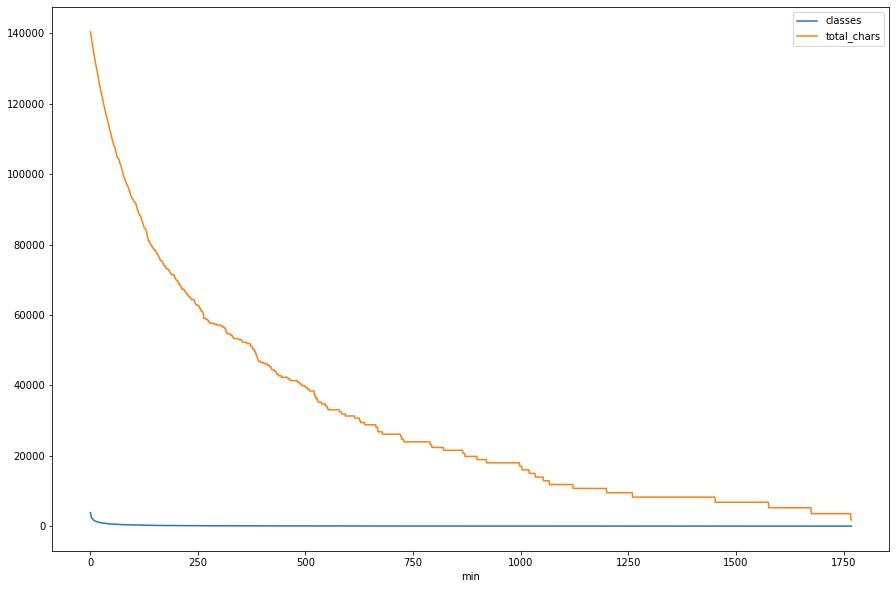

In [206]:
sizes.plot(figsize=(15,10))

By filtering out the categories with less than 10 observations, 1566 classes remain.

In [208]:
sizes.loc[10]

classes          1566
total_chars    133480
Name: 10, dtype: int64

I duplicate those files and send them to their own respective train, test, and validation paths within their own class subdirectories.

In [8]:
#Creates path references for the soon to be created train, validation, and split directories.
kanji_train = os.path.join(split_kanji_dir, "train")
kanji_val = os.path.join(split_kanji_dir, "val")
kanji_test = os.path.join(split_kanji_dir, "test")

In [330]:
#Creates the directories.
os.makedirs(kanji_train)
os.makedirs(kanji_val)
os.makedirs(kanji_test)

In [331]:
# Creates directories for the classes that meet the threshold.
kanji_dir_list = directory_counts[directory_counts["count"] >= 10]["folder"].to_numpy().tolist()

In [ ]:
# A simple split for the image files within their own locations. The characters don't seem to have any order to them within
# their class directories so no random influences were added to the split.
for directory in kanji_dir_list:
    paths = image_path_extractor(directory, orig_kuzushiji_kanji_dir, random_seed=SEED)
    train, val, test = image_path_list_train_test_split(paths, .7, .1)
    
    # Copies the files to their new locations.
    image_path_copier(train, orig_kuzushiji_kanji_dir, kanji_train, directory)
    image_path_copier(val, orig_kuzushiji_kanji_dir, kanji_val, directory)
    image_path_copier(test, orig_kuzushiji_kanji_dir, kanji_test, directory)

The remaining kanji characters with less than 10 observations might be useful in their aggregate form as a class of their own. Ideally, it would likely be more optimal to group similar kanji to divide this class and while making logical connections for the classifier, but it would be a major sacrifice to time to examine the classes individually.

In [333]:
sizes.loc[1]["total_chars"]-sizes.loc[10]["total_chars"]

6944

In [334]:
other_dirs = directory_counts[directory_counts["count"] < 10]["folder"].to_numpy().tolist()
other_paths = image_path_extractor(other_dirs, orig_kuzushiji_kanji_dir, random_seed=SEED)

train, val, test = image_path_list_train_test_split(other_paths, .7, .1)

#Copies the files to their new subdirectories.
image_path_copier(train, orig_kuzushiji_kanji_dir, kanji_train, "other")
image_path_copier(val, orig_kuzushiji_kanji_dir, kanji_val, "other")
image_path_copier(test, orig_kuzushiji_kanji_dir, kanji_test, "other")

4860 files copied to data/kuzushiji49/kanji_transfer/train/other
1389 files copied to data/kuzushiji49/kanji_transfer/val/other
695 files copied to data/kuzushiji49/kanji_transfer/test/other


### EMNIST

The kanji dataset is not that large even with the readdition of the dropped classes. Also the written strokes of Hiragana and Kanji are more different from one another to a greater degree than something like Katakana and Kanji. It's hard to quantify but Hiragana has a more curved look and feel to it.

For those reasons I also brought in the [EMNIST ByMerge dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset). By including the vastly different western character set, I hoped to increase the model's ability to generalize. What set's the bymerge dataset apart from the othes is that the letters are grouped together when there is significant visual overlap (ie C vs c). This model is just to create a strong convolutional base so those points of contention are better avoided.

In [162]:
#Imports the data
emnist_train_data = parse_emnist("data/emnist/emnist-bymerge-train-images-idx3-ubyte.gz")
emnist_train_labels = parse_emnist("data/emnist/emnist-bymerge-train-labels-idx1-ubyte.gz", offset=8, isimg=False)
emnist_test_data = parse_emnist("data/emnist/emnist-bymerge-test-images-idx3-ubyte.gz")
emnist_test_labels = parse_emnist("data/emnist/emnist-bymerge-test-labels-idx1-ubyte.gz", offset=8, isimg=False)

In [163]:
# Pads the images to go from 28x28 to 32x32 to avoid cropping/arififacts being introduced from the random transformations.
emnist_train_data = pad_raster_edges(emnist_train_data, 2, 2)
emnist_test_data = pad_raster_edges(emnist_test_data, 2, 2)

In [164]:
full_value_counts(pd.DataFrame(emnist_train_labels), 0)

There are 47 unique values with 0 nan values making up 0.0%
38304-1 --5.49%
36020-7 --5.16%
35285-3 --5.06%
34618-0 --4.96%
34307-2 --4.92%
34150-6 --4.89%
33924-8 --4.86%
33882-9 --4.85%
33656-4 --4.82%
31280-5 --4.48%
27664-24 --3.96%
24657-39 --3.53%
23509-28 --3.37%
20381-21 --2.92%
18248-46 --2.61%
15388-30 --2.20%
14733-18 --2.11%
14060-45 --2.01%
12963-12 --1.86%
11612-22 --1.66%
11444-43 --1.64%
10748-25 --1.54%
10152-38 --1.45%
10009-36 --1.43%
9766-29 --1.40%
9098-15 --1.30%
8682-42 --1.24%
8237-23 --1.18%
7588-31 --1.09%
7403-32 --1.06%
7092-34 --1.02%
6411-10 --0.92%
5689-19 --0.82%
5598-33 --0.80%
5416-35 --0.78%
5080-37 --0.73%
5047-27 --0.72%
4998-20 --0.72%
4925-14 --0.71%
4606-13 --0.66%
3874-11 --0.56%
3693-41 --0.53%
3097-17 --0.44%
2966-44 --0.42%
2603-26 --0.37%
2535-40 --0.36%
2534-16 --0.36%


The amount of observations in this dataset vastly exceed the observations in the kanji set. To prevent these observations from overwhelming the rest of the data, I've downsampled to the lowest value since, 2534 observations is still significant in comparison.

In [165]:
#My resample function requires each observation to be a vector, so the images are reshaped before resampling
emnist_train_data, emnist_train_labels = preprocess_raster_resampling(images_to_1d(emnist_train_data), emnist_train_labels, "downsample", random_state=SEED)
emnist_test_data, emnist_test_labels = preprocess_raster_resampling(images_to_1d(emnist_test_data), emnist_test_labels, "downsample", random_state=SEED)

#Creates a validation set
emnist_train_X, emnist_val_X, emnist_train_y, emnist_val_y = train_test_split(emnist_train_data, emnist_train_labels, test_size=.2, random_state=SEED)

# Restoring the original shape while explicitly adding it's color channel.
emnist_train_X = images_to_1d(emnist_train_X, 32, 32, 1, inverse=True)
emnist_val_X = images_to_1d(emnist_val_X, 32, 32, 1, inverse=True)
emnist_test_data = images_to_1d(emnist_test_data, 32, 32, 1, inverse=True)

performing downsample
performing downsample


In [180]:
# Exports the splits to their respective directories. These groups will be identifiable with the emnist prefix to their directories. 
emist_pref = "emnist_"
export_numpy_array_to_images(emnist_train_X, emnist_train_y, kanji_train, emist_pref)
export_numpy_array_to_images(emnist_val_X, emnist_val_y, kanji_val, emist_pref)
export_numpy_array_to_images(emnist_test_data, emnist_test_labels, kanji_test, emist_pref)

### Obsolete Kana


Finally, it might help to add in those obsolete observations from the hiragana set to build a more robust base for transfer learning. The proprocessing at this stage will be with a lighter touch since it will be heppening after the image sets are exported and reimported with the rest of the images.

In [200]:
# Importing the datasets
obs_kana_train_data = np.load("data/kuzushiji49/train/k49-train-imgs.npz")['arr_0']
obs_kana_train_labels = np.load("data/kuzushiji49/train/k49-train-labels.npz")['arr_0']
obs_kana_test_data = np.load("data/kuzushiji49/test/k49-test-imgs.npz")['arr_0']
obs_kana_test_labels = np.load("data/kuzushiji49/test/k49-test-labels.npz")['arr_0']

# Eliminating the classes that are already used in the main model.
obsolete_mask_train = (obs_kana_train_labels == 44) | (obs_kana_train_labels == 45) | (obs_kana_train_labels == 48)
obsolete_mask_test = (obs_kana_test_labels == 44) | (obs_kana_test_labels == 45) | (obs_kana_test_labels == 48)
obs_kana_train_data, obs_kana_train_labels = obs_kana_train_data[obsolete_mask_train], obs_kana_train_labels[obsolete_mask_train]
obs_kana_test_data, obs_kana_test_labels = obs_kana_test_data[obsolete_mask_test], obs_kana_test_labels[obsolete_mask_test]

# Match kanji folder structure by replacing the key with the unicode value.
to_replace, unicode_sym = 44, "U+3090"
obs_kana_train_labels, obs_kana_test_labels = np.where(obs_kana_train_labels == to_replace, unicode_sym, obs_kana_train_labels), np.where(obs_kana_test_labels == to_replace, unicode_sym, obs_kana_test_labels)

to_replace, unicode_sym = "45", "U+3091"
obs_kana_train_labels, obs_kana_test_labels = np.where(obs_kana_train_labels == to_replace, unicode_sym, obs_kana_train_labels), np.where(obs_kana_test_labels == to_replace, unicode_sym, obs_kana_test_labels)

to_replace, unicode_sym = "48", "U+309E"
obs_kana_train_labels, obs_kana_test_labels = np.where(obs_kana_train_labels == to_replace, unicode_sym, obs_kana_train_labels), np.where(obs_kana_test_labels == to_replace, unicode_sym, obs_kana_test_labels)

#Adding the padding to make all images 32x32 and allow for edge buffer during transformations.
obs_kana_train_data = pad_raster_edges(obs_kana_train_data, 2, 2)
obs_kana_test_data = pad_raster_edges(obs_kana_test_data, 2, 2)

#Creates a validation set
obs_kana_train_X, obs_kana_val_X, obs_kana_train_y, obs_kana_val_y = train_test_split(obs_kana_train_data, obs_kana_train_labels, test_size=.2, random_state=SEED)

# Restoring the original shape while explicitly adding it's color channel.
obs_kana_train_X = images_to_1d(obs_kana_train_X, 32, 32, 1, inverse=True)
obs_kana_val_X = images_to_1d(obs_kana_val_X, 32, 32, 1, inverse=True)
obs_kana_test_data = images_to_1d(obs_kana_test_data, 32, 32, 1, inverse=True)

In [203]:
export_numpy_array_to_images(obs_kana_train_X, obs_kana_train_y, kanji_train)
export_numpy_array_to_images(obs_kana_val_X, obs_kana_val_y, kanji_val)
export_numpy_array_to_images(obs_kana_test_data, obs_kana_test_labels, kanji_test)

## Preprossessing

In [6]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=4,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
test_generator = ImageDataGenerator(rescale=1./255)

In [17]:
X_train_generator = train_generator.flow_from_directory(kanji_train, target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_val_generator = test_generator.flow_from_directory(kanji_val, target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_test_generator = test_generator.flow_from_directory(kanji_test, target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 34967)

Found 196357 images belonging to 1617 classes.
Found 52741 images belonging to 1617 classes.
Found 34967 images belonging to 1617 classes.


## Modeling

### Baseline Predictor

While the models in this notebook are intended for transfer learning, it is still good to see how effective it is in predicting across all of the many classes.

In [11]:
X_dummy_train_generator = train_generator.flow_from_directory(kanji_train, target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 196357)
X_dummy_test_generator = test_generator.flow_from_directory(kanji_test, target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 34967)

dummmy_train, dummy_test = next(X_dummy_train_generator), next(X_dummy_test_generator)

dummy_X_train, dummy_y_train = dummmy_train[0], np.argmax(dummmy_train[1], axis=1)
dummy_X_test, dummy_y_test = dummy_test[0], np.argmax(dummy_test[1], axis=1)

baseline_predictor = DummyClassifier(strategy="stratified", random_state=SEED)
baseline_predictor.fit(dummy_X_train, dummy_y_train)
y_hat = baseline_predictor.predict(dummy_X_test)
image_class_accuracy_scores(dummy_y_test, y_hat)

Found 196357 images belonging to 1617 classes.
Found 34967 images belonging to 1617 classes.
Accuracy: 0.007292590156433208
Balanced Accuracy: 0.00047269533690137645


(0.007292590156433208, 0.00047269533690137645)

### The CNN for Transfer Learning

In [18]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(X_train_generator.classes), 
            X_train_generator.classes)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[   0    1    2 ... 1614 1615 1616], y=[   0    0    0 ... 1616 1616 1616] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [19]:
layers = [Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32 ,32,  1)),
          Conv2D(32, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(1000, "relu"),
          Dense(1617, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelk1 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
backups = ModelCheckpoint("model_backups/kanji/modelk1-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

resultsk1 = modelk1.fit(X_train_generator, epochs=200, steps_per_epoch=6136, validation_data=X_val_generator, validation_steps=1648, class_weight=class_weights, callbacks=[backups, stopping])

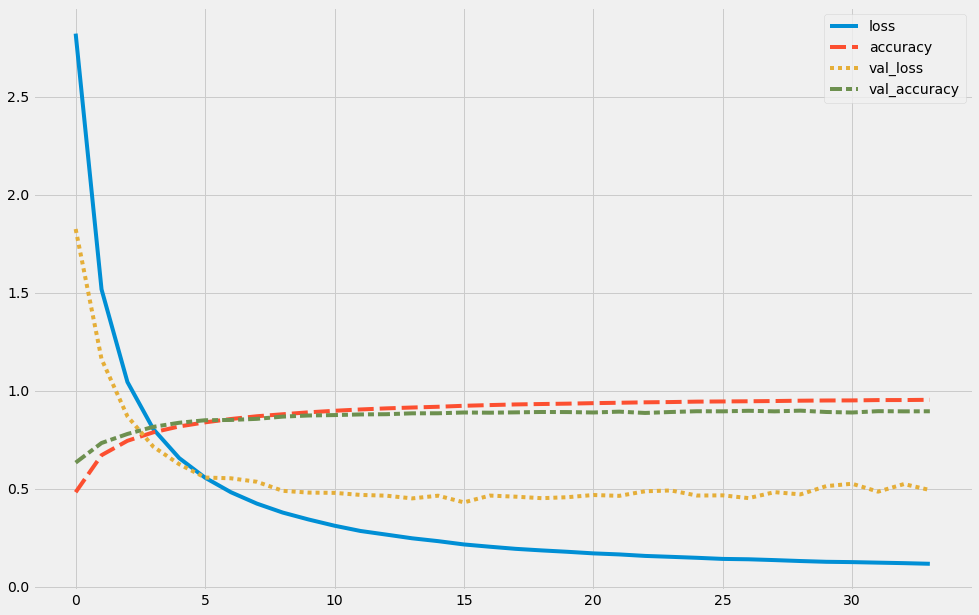

,loss,accuracy,val_loss,val_accuracy
29,0.127199,0.950353,0.513492,0.891630
30,0.125590,0.950699,0.525429,0.889013
31,0.122895,0.952400,0.485153,0.895783
32,0.120332,0.952563,0.523881,0.894911
33,0.117031,0.953811,0.493380,0.895290


In [24]:
plot_keras_fit_history(resultsk1, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [23]:
test_batch = next(X_test_generator)
image_class_evaluation(modelk1, test_batch[0], test_batch[1])

Accuracy: 0.8908971315812051
Balanced Accuracy: 0.7681570807141194


(0.8908971315812051, 0.7681570807141194)